In [1]:
from matplotlib import lines
from tqdm.autonotebook import tqdm

if __name__ == "__main__":
    from cProfile import label
    from copy import deepcopy
    import logging
    from multiprocessing import process 
    from venv import logger
    from matplotlib.colors import Normalize
    from matplotlib.transforms import offset_copy

    import numpy as np
    import matplotlib.pyplot as plt
    import datetime

    from oap_model.intensity import AmplitudeField
    from oap_model.psd import GammaPSD, CrystalModel
    from oap_model.cloud import CloudVolume, Detector
    from oap_model.detector import Detector, DiameterSpec
    from oap_model.retrieval import Retrieval
    from oap_model.detector_run import DetectorRun

    from extras.profiler import profile


/var/folders/7p/q_zbbty53wg88yq0k8d1k0200000gp/T/ipykernel_6890/2526340320.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [12]:
logging.basicConfig(level=logging.INFO)

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 10
plt.rcParams["text.usetex"] = False
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"



save_figures=False

In [3]:
@profile(f"../data/profile__take_image__{datetime.datetime.now():%Y-%m-%d_%H%M}.prof")
def take_image(detector, distance, cloud: CloudVolume, single_image=False, binary_output=False, **kwargs):
    return cloud.take_image(detector, distance=distance, single_image = single_image, binary_output=binary_output)

def make_run(shape, cloud,  distance, n_px, det_len=np.inf, plot=True, px_size=10, save_run=False, offset=0, identifier=None, binary_output=False, **kwargs):
    detector_run_version=12
    cloud.set_model(shape)

    base_distance = np.max(distance)
    file_name = f"run_v{detector_run_version}_{base_distance:.1f}_{n_px}px_{shape.name}_{identifier+'_' if identifier else ''}run".replace(".", "_")
    logging.info(f"Processing {file_name}")
    detector = Detector(np.array([0.005, 0.1+offset, 0.01]), n_pixels=n_px, arm_separation=0.06, detection_length=det_len, pixel_size=px_size*1e-6)
    try:
        base_run = DetectorRun.load(f"../data/{file_name}.pkl")
        base_run.detector = detector
        logging.info(f"Loaded run from file {file_name}.pkl")
    except FileNotFoundError:
        # run = cloud.take_image(detector, distance=distance, separate_particles=True)
        base_run = take_image(detector, base_distance, cloud, binary_output=binary_output)
        if save_run:
            base_run.save(f"../data/{file_name}.pkl")
            logging.info(f"Saved run to file {file_name}.pkl")


    diameter_spec = DiameterSpec(min_sep=5e-4, z_confinement=True if det_len < np.inf else False)

    distance = [distance] if isinstance(distance, (int, float)) else distance
    
    base_retrieval = Retrieval(base_run, diameter_spec)
    retrievals = [base_retrieval.slice(run_distance) for run_distance in distance]
    # retrievals = [Retrieval(run, diameter_spec) for run in runs]
    if plot:
        [retrieval.fancy_plot(cloud, **kwargs) for retrieval in retrievals]

    return base_run, retrievals


/var/folders/7p/q_zbbty53wg88yq0k8d1k0200000gp/T/ipykernel_6890/2072544575.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{1e6*tick:.0f}" for tick in ax.get_xticks()])


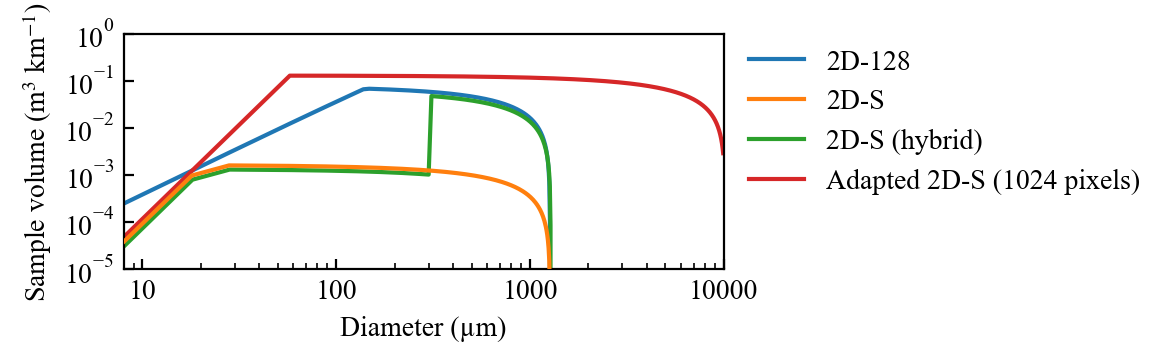

In [4]:

# # %% plot sample volume as a function of diameter
run_2d128_for_volume = DetectorRun(Detector(np.array([0,0,0]), 0.06), [], 1000)
run_2ds_for_volume = DetectorRun(Detector(np.array([0,0,0]), 0.06, detection_length=128*10e-6), [], 1000)
run_2ds_1024_for_volume = DetectorRun(Detector(np.array([0,0,0]), 0.06, detection_length=1024*10e-6, n_pixels=1024), [], 1000)

diameters = np.linspace(8e-6, 10e-3, 1000)

volumes_2d128 = [run_2d128_for_volume.volume(diameter) for diameter in diameters]
volumes_2ds = [run_2ds_for_volume.volume(diameter, DiameterSpec(z_confinement=True)) for diameter in diameters]
volumes_2ds_hybrid = [run_2d128_for_volume.volume(diameter) if diameter > 300e-6 else run_2ds_for_volume.volume(diameter, DiameterSpec(z_confinement=True)) for diameter in diameters]
volumes_2ds_1024 = [run_2ds_1024_for_volume.volume(diameter, DiameterSpec(z_confinement=True)) for diameter in diameters]



fig, ax = plt.subplots(figsize=(6,2))
tr = offset_copy(ax.transData, fig=fig, x=0.2, y=-1.5, units='points')
tr2 = offset_copy(ax.transData, fig=fig, x=-0.2, y=1.5, units='points')
ax.plot(diameters, volumes_2d128, label="2D-128")
ax.plot(diameters, volumes_2ds, label="2D-S", zorder=9999)
ax.plot(diameters, volumes_2ds_hybrid, label="2D-S (hybrid)",transform=tr)
ax.plot(diameters, volumes_2ds_1024, label="Adapted 2D-S (1024 pixels)", transform=tr2)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1.04), frameon=False)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(left=8e-6, right=10e-3)
ax.set_ylim(1e-5)
ax.set_ylabel("Sample volume (m$^3$ km$^{-1}$)")
ax.set_xlabel("Diameter (µm)")
ax.set_yticks([1e-5,1e-4,1e-3, 1e-2, 1e-1, 1])
plt.tight_layout()
ax.set_xticklabels([f"{1e6*tick:.0f}" for tick in ax.get_xticks()])

if save_figures:
    plt.savefig("../report/img/sample-volume.pdf", bbox_inches="tight")
plt.show()


In [5]:
gammas = {
    ("in-situ", "cold"): GammaPSD.w19_parameterisation(-70, total_number_density=44, insitu_origin=True),
    ("in-situ", "hot"): GammaPSD.w19_parameterisation(-50, total_number_density=44, insitu_origin=True),
    ("liquid", "cold"): GammaPSD.w19_parameterisation(-60, total_number_density=44, liquid_origin=True),
    ("liquid", "hot"): GammaPSD.w19_parameterisation(-40, total_number_density=44, liquid_origin=True),
}


clouds_ensemble = []
for i in range(1):
    gamma_clouds = {}
    for labels, gamma in gammas.items():
        gamma_clouds[labels] = CloudVolume(gamma, (0.1, 25_001, 0.1), random_seed=i)
    
    clouds_ensemble.append(gamma_clouds)

logger.info("Calculating means and number densities...")
for labels, gamma in gammas.items():
    logging.info(f"{labels}: n_0 {gamma.total_number_density:.2f} m-3; D_mean {gamma.mean*1e6:.2f} um")
print()

def process_residuals(n_pts, n_px, max_len, cloud, px_size, det_len, identifier, shape, moments=[0], binary_output=False):

    max_len_power = np.log10(max_len)
    # residuals = np.zeros((n_pts, n_px-1))
    run_distances = np.logspace(0,max_len_power, n_pts)
    run, retrievals = make_run(
        shape,
        cloud,
        run_distances, 
        n_px, 
        px_size=px_size, 
        plot=False, 
        save_run=True,
        make_fit=False,
        det_len=det_len,
        identifier=identifier,
        binary_output=binary_output
    )

    moment_residuals = {}
    if 0 not in moments:
        moments = moments + [0]

    for moment in moments:
        residuals = np.zeros((n_pts, n_px-1))
        for i, retrieval in enumerate(retrievals):
            true_psd = cloud.psd.dn_dd(retrieval.midpoints)
            residuals[i,:] =  (retrieval.dn_dd_measured - true_psd)* (retrieval.midpoints/cloud.psd.mean)**moment
        
        moment_residuals[moment] = deepcopy(residuals)

    return moment_residuals, retrievals


def residuals_in_context(shape, z_confinement, identifier, n_px=128, px_size=10, max_len=10_000, n_pts=51, residual_labels=None, moments=[0], binary_output=True):
    det_len = n_px*px_size*1e-6 if z_confinement else np.inf
    true_psd = None
    cloud_len = max_len + 1
    max_len_power = np.log10(max_len)

    iterator = gamma_clouds.keys() if residual_labels is None else [residual_labels]

    best_retrievals = {}
    gamma_residuals = {}
    for labels in iterator:
        cloud = gamma_clouds[labels]

        moment_residuals, retrievals = process_residuals(n_pts, n_px, max_len, cloud, px_size, det_len, identifier+"-"+labels[0]+"-"+labels[1], shape, moments=moments, binary_output=binary_output)
        
        best_retrievals[labels] = deepcopy(retrievals[-1])

        for moment in moments:
            if moment != 0:
                residual_labels = (*labels, moment)
            else:
                residual_labels = labels
            gamma_residuals[residual_labels] = moment_residuals[moment]

        del retrievals
    
    return best_retrievals, gamma_residuals

def plot_residuals(residuals, best_retrieval, px_size=10, n_px=128, max_len=10_000, n_pts=51):
    run_distances=np.logspace(0,np.log10(max_len),n_pts)
    
    # find the last bin with data
    last_bin = np.where(best_retrieval.dn_dd_measured != 0)[0].max()
    norm = plt.Normalize(vmin=0, vmax=last_bin)
    cmap = plt.cm.viridis
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    # Conventional scale
    fig, ax = plt.subplots()
    for i, x_px in tqdm(enumerate(np.linspace(px_size,px_size*(n_px+1), n_px-1))):
        if i > last_bin:
            break
        ax.plot(run_distances, residuals[:,i], label=f"{x_px:.0f} µm", color=cmap(norm(i)), linewidth=1)
    fig.colorbar(cbar, label="Diameter/pixels")
    ax.hlines([0], 0, n_pts-1, color="grey", linestyle="dotted")
    # plt.title(f"Fitting {shape.name} PSD with {n_px}x{px_size} µm pixels, with {f'{det_len:.3e}' if z_confinement else 'no'} z confinement")
    plt.ylabel("Residuals/ $\mathrm{m^{-3} m^{-1}}$")
    plt.xlabel("Distance/ m")
    # ax.set_ylim(-0.15e9,1.75e9)
    ax.set_xlim(0, run_distances[-1])
    # ax.text(0.05, 0.95, f"{labels[0]} origin, {labels[1]}", transform=ax.transAxes, verticalalignment='top')

def plot_residual_heatmap(residuals, best_retrieval=None, px_size=10, max_len=10_000, n_pts=51, true_psd=None, normalised=False):
    run_distances=np.logspace(0,np.log10(max_len),n_pts)
    # Heatmap
    if best_retrieval is not None:
        last_bin = np.where(best_retrieval.dn_dd_measured != 0)[0].max()
    else:
        last_bin = residuals.shape[1]-1
    x_mesh = run_distances
    y_mesh = np.arange(px_size,px_size*(last_bin+1.1), px_size)

    fig, ax = plt.subplots()
    # extreme_value = np.abs(residuals).max()
    # final_iqr = np.percentile(residuals[-1,:last_bin+1], 90) - np.percentile(residuals[-1,:last_bin+1], 10)
    if normalised:
        norm = plt.cm.colors.SymLogNorm(linthresh=0.075, linscale=1, vmin=-10, vmax=10)
    else:
        linthresh = true_psd.max_dn_dd if true_psd is not None else 2e7
        norm = plt.cm.colors.SymLogNorm(linthresh=linthresh/2, linscale=1, vmin=-2e9, vmax=2e9)
    plt.pcolormesh(x_mesh, y_mesh,residuals[:, :last_bin+1].T, cmap="PiYG", norm=norm)#, extent=[0, run_distances[-1], px_size, px_size*(last_bin+1)], aspect="auto")
    plt.colorbar()
    # ax.hlines([0], 0, n_pts-1, color="grey", linestyle="dotted")
    # plt.title(f"Fitting {shape.name} PSD with {n_px}x{px_size} µm pixels, with {det_len if z_confinement else 'no'} z confinement")
    plt.ylabel("Diameter/ µm")
    plt.xlabel("Distance/ m")
    ax.set_xscale("log")
    # ax.set_ylim(-0.15e9,1.75e9)
    # ax.set_xlim(0, run_distances[-1])
    # ax.text(0.05, 0.95, f"{labels[0]} origin, {labels[1]}", transform=ax.transAxes, verticalalignment='top')
    # plt.show()

def retrieval_plots(best_retrievals, gamma_residuals, gamma_label, moment=0):
    gamma = gamma_label
    if moment != 0:
        residuals_label = gamma_label + (moment,)
    else:
        residuals_label = gamma_label

    # plot_residuals(gamma_residuals[residuals_label], best_retrievals[gamma], max_len=base_run_len, n_pts=n_pts)
    # plt.title(shape_instrument+f"_{gamma[0]}-{gamma[1]}")
    # plot_residual_heatmap(gamma_residuals[residuals_label], best_retrievals[gamma], max_len=base_run_len, n_pts=n_pts, true_psd=gammas[gamma])
    # plt.title(shape_instrument+f"_{gamma[0]}-{gamma[1]}")
    fig, axs = best_retrievals[gamma].fancy_plot(gamma_clouds[gamma], make_fit=False, plot_true_adjusted=False)
    # axs[0].set_xscale("log")
    fig.suptitle(shape_instrument+f"_{gamma[0]}-{gamma[1]}")
    plt.show()

# def retrieve_and_plot(shape, z_confinement, gamma_labels, sample_len=10_000, n_pts=51, n_px=128):
#     best_retrievals, gamma_residuals = residuals_in_context(shape, z_confinement, "2d128", n_px=n_px, px_size=10, max_len=sample_len, n_pts=n_pts, residual_labels=gamma_labels, moments=[0,1,3,6])
#     retrieval_plots(best_retrievals, gamma_residuals)


INFO:root:Initialising cloud volume
INFO:root:Generating grid of dimensions: [100000, 25001000000, 100000] points.
INFO:root:Generating 11000440 particles
INFO:root:Initialising cloud volume
INFO:root:Generating grid of dimensions: [100000, 25001000000, 100000] points.
INFO:root:Generating 11000439 particles
INFO:root:Initialising cloud volume
INFO:root:Generating grid of dimensions: [100000, 25001000000, 100000] points.
INFO:root:Generating 11000111 particles
INFO:root:Initialising cloud volume
INFO:root:Generating grid of dimensions: [100000, 25001000000, 100000] points.
INFO:root:Generating 10999103 particles
INFO:venv:Calculating means and number densities...
INFO:root:('in-situ', 'cold'): n_0 44000.00 m-3; D_mean 23.46 um
INFO:root:('in-situ', 'hot'): n_0 44000.00 m-3; D_mean 21.95 um
INFO:root:('liquid', 'cold'): n_0 43998.69 m-3; D_mean 101.42 um
INFO:root:('liquid', 'hot'): n_0 43994.65 m-3; D_mean 89.91 um


In [6]:
results_ensemble = []
for i, gamma_clouds in enumerate(clouds_ensemble):
    results = {}
    shapes = [CrystalModel.SPHERE, CrystalModel.RECT_AR5]
    z_confinements = [True, False]

    n_pts = 51
    base_run_len=200 


    for shape in shapes:
        for z_confinement in z_confinements:
            best_retrievals, gamma_residuals = residuals_in_context(shape, z_confinement, f"2d128_repeat{i}", n_px=128, px_size=10, max_len=base_run_len, n_pts=n_pts, moments=[0,1,3,6])
            label = shape.name + ("_2ds" if z_confinement else "_2d128")
            results[label] = (best_retrievals, gamma_residuals)
    
    results_ensemble.append(results)


INFO:root:Processing run_v12_200_0_128px_SPHERE_2d128_repeat0-in-situ-cold_run
INFO:root:Loaded run from file run_v12_200_0_128px_SPHERE_2d128_repeat0-in-situ-cold_run.pkl
INFO:root:Processing run_v12_200_0_128px_SPHERE_2d128_repeat0-in-situ-hot_run
INFO:root:Loaded run from file run_v12_200_0_128px_SPHERE_2d128_repeat0-in-situ-hot_run.pkl
INFO:root:Processing run_v12_200_0_128px_SPHERE_2d128_repeat0-liquid-cold_run
INFO:root:Loaded run from file run_v12_200_0_128px_SPHERE_2d128_repeat0-liquid-cold_run.pkl
INFO:root:Processing run_v12_200_0_128px_SPHERE_2d128_repeat0-liquid-hot_run
INFO:root:Loaded run from file run_v12_200_0_128px_SPHERE_2d128_repeat0-liquid-hot_run.pkl
INFO:root:Processing run_v12_200_0_128px_SPHERE_2d128_repeat0-in-situ-cold_run
INFO:root:Loaded run from file run_v12_200_0_128px_SPHERE_2d128_repeat0-in-situ-cold_run.pkl
INFO:root:Processing run_v12_200_0_128px_SPHERE_2d128_repeat0-in-situ-hot_run
INFO:root:Loaded run from file run_v12_200_0_128px_SPHERE_2d128_repeat

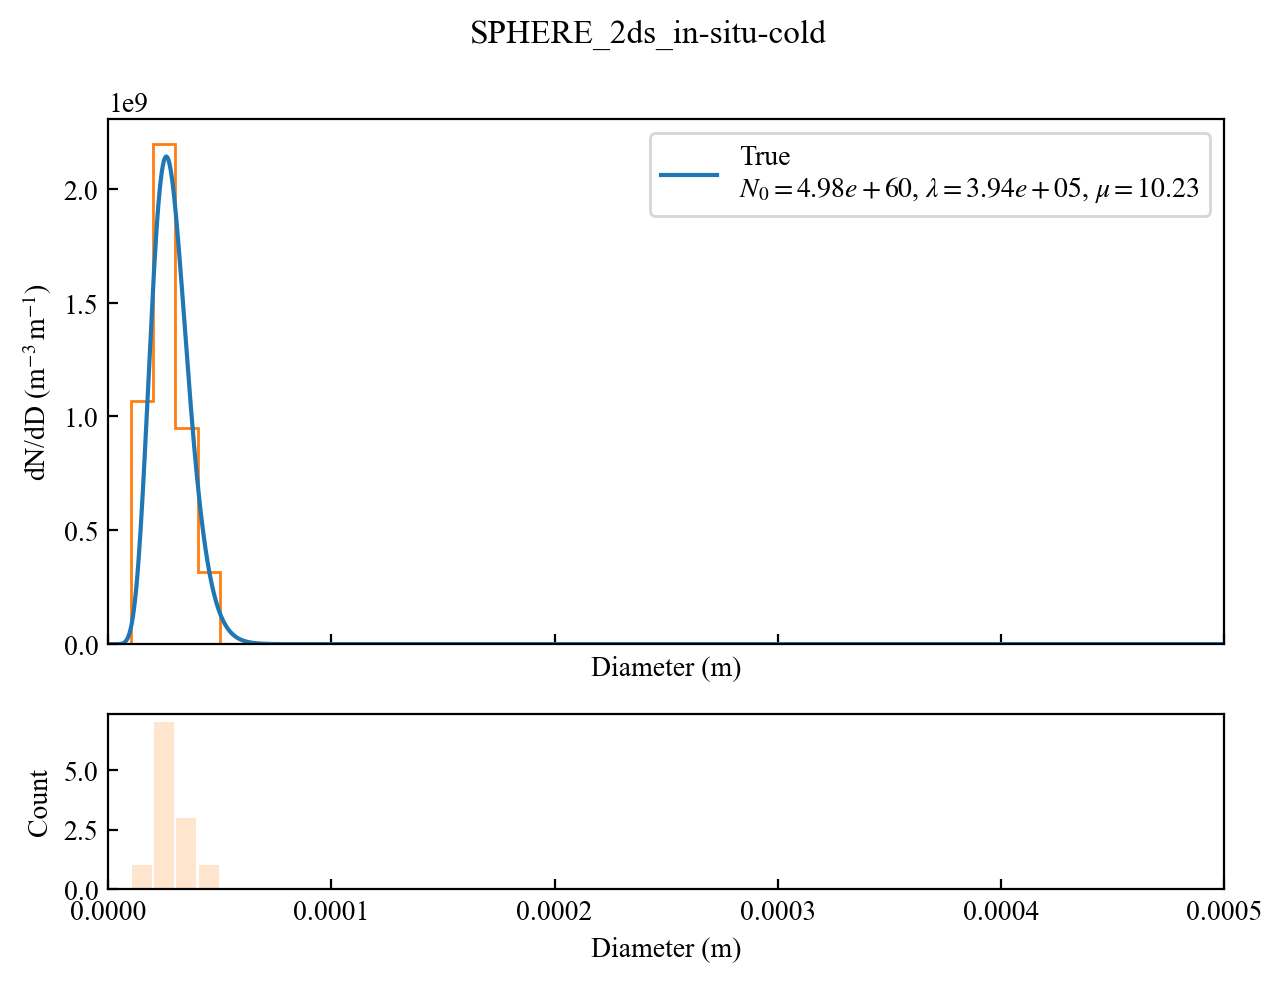

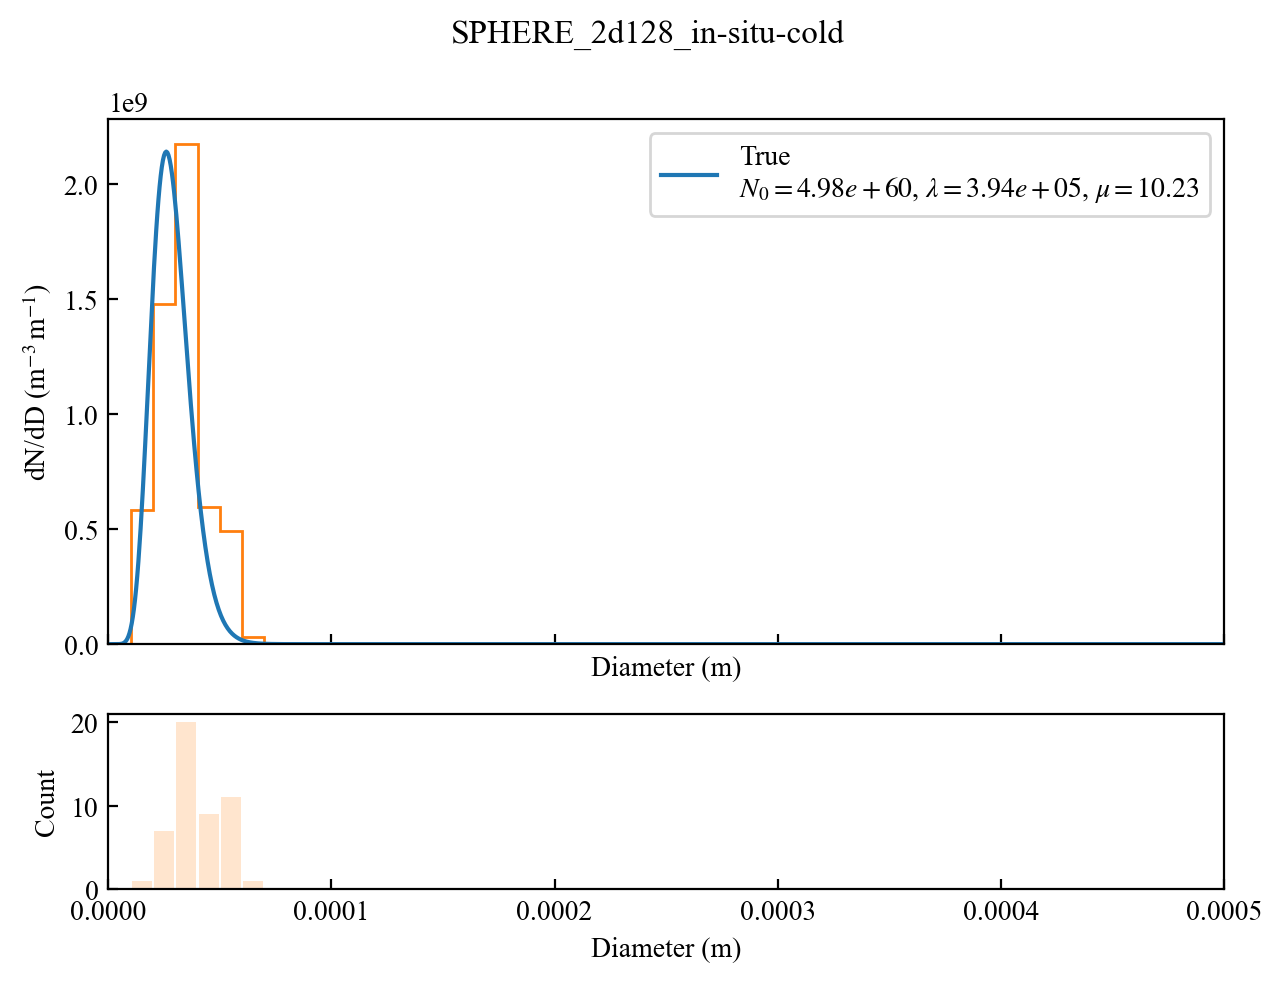

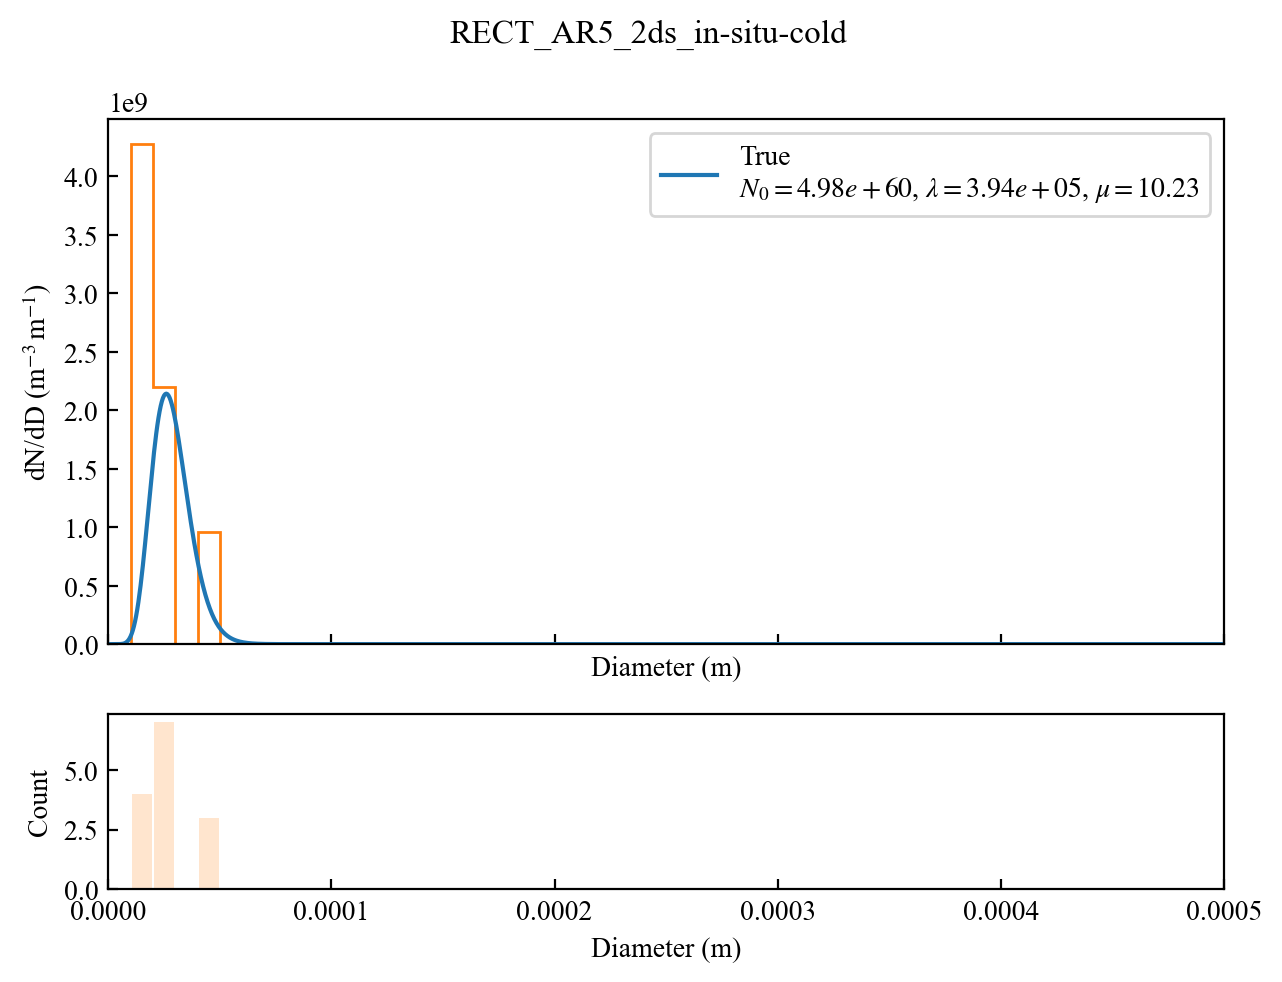

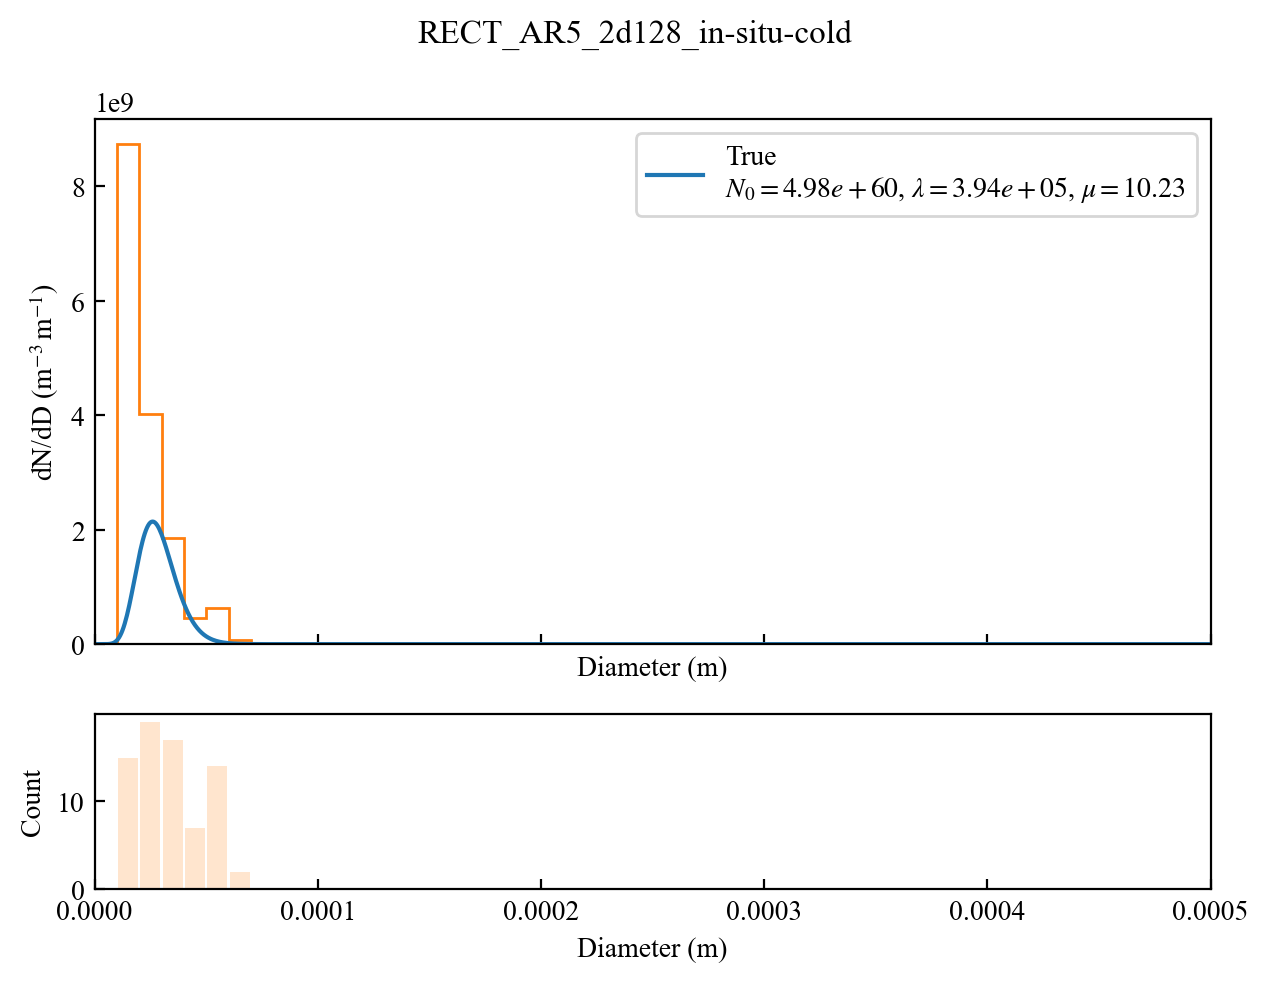

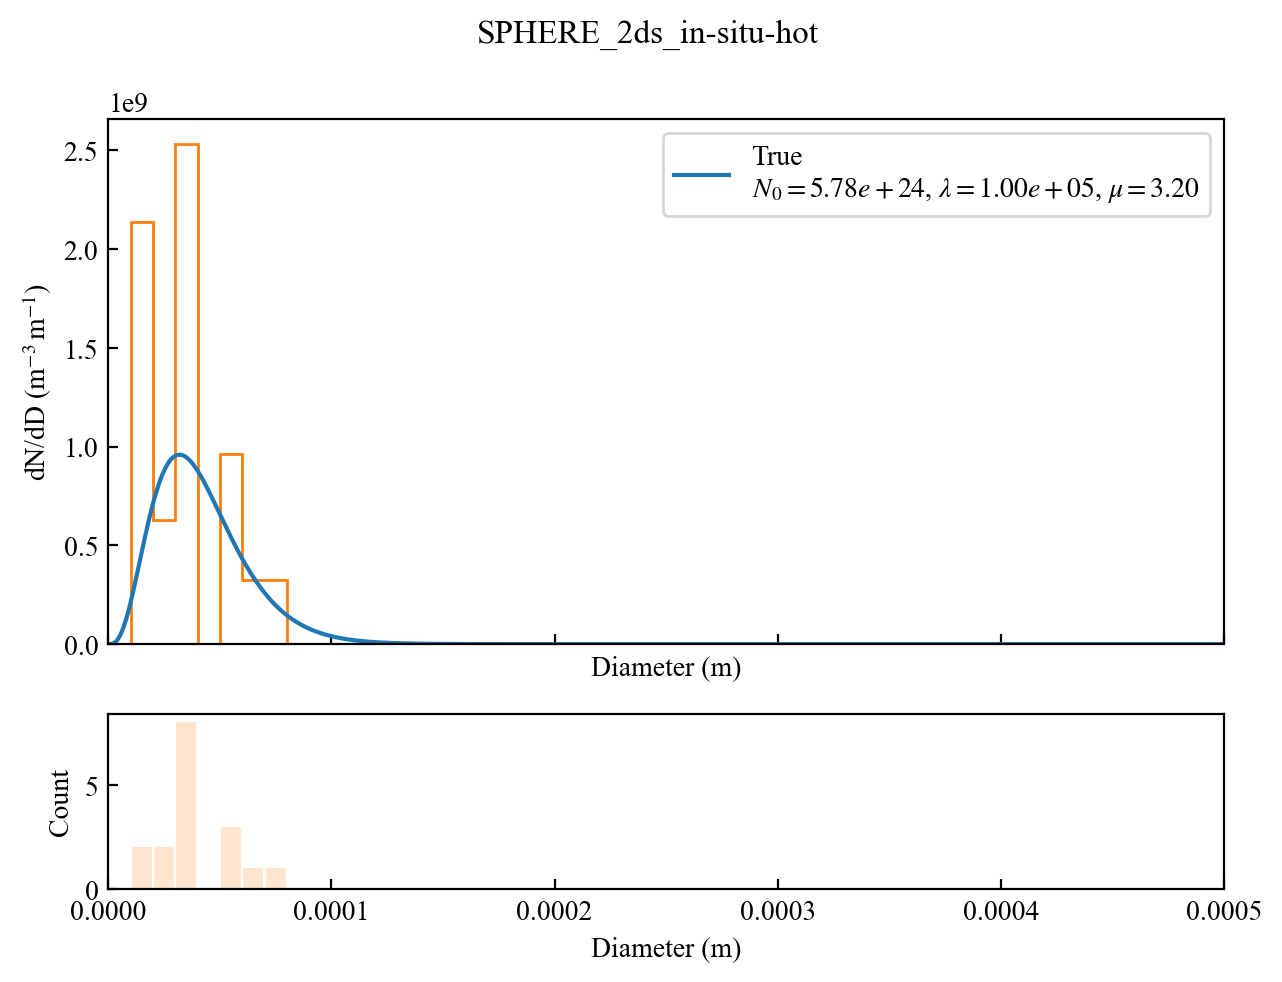

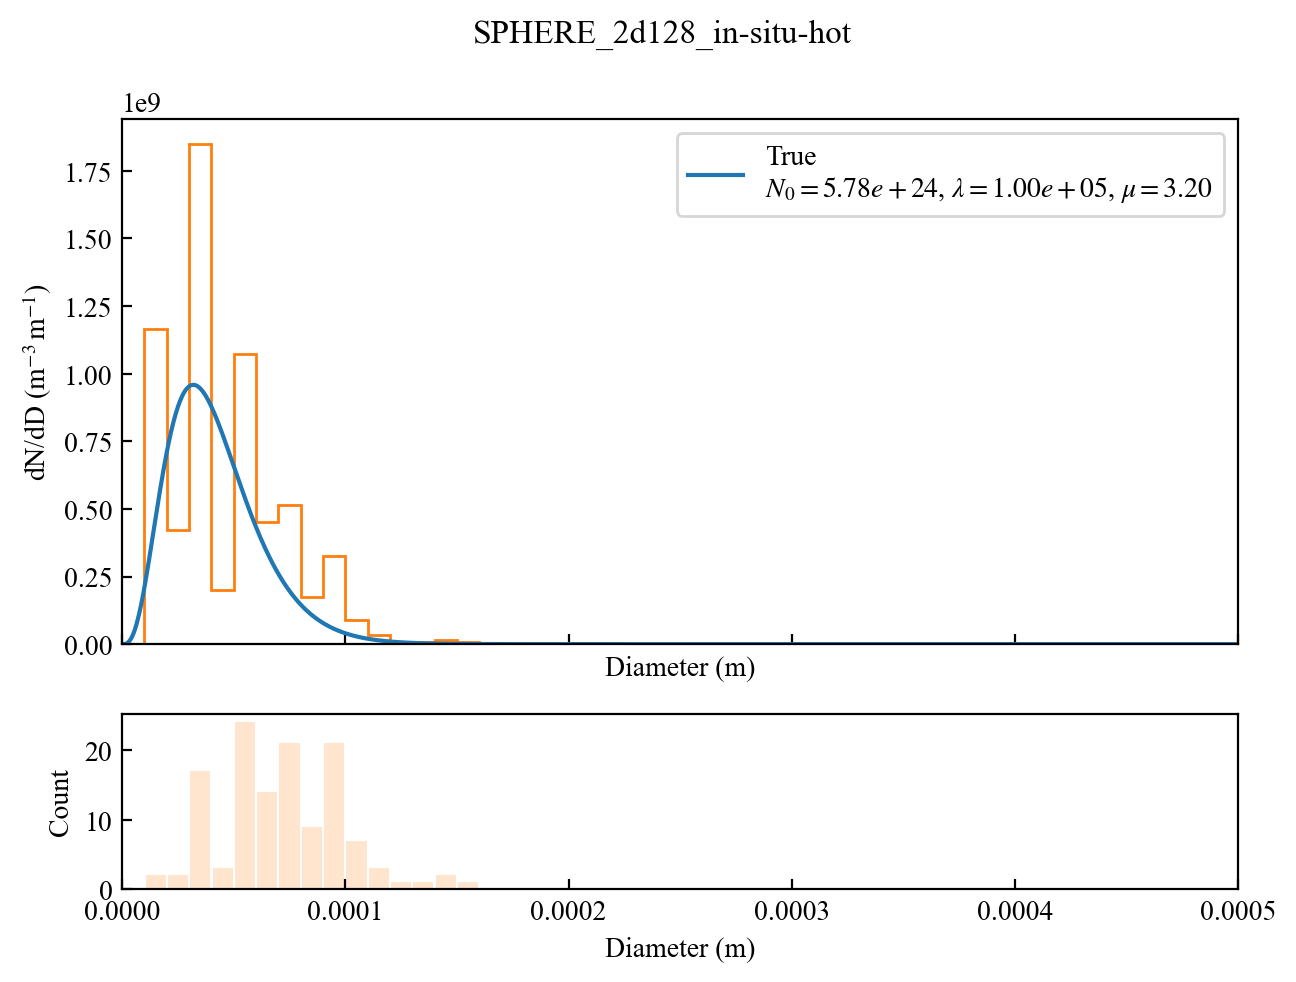

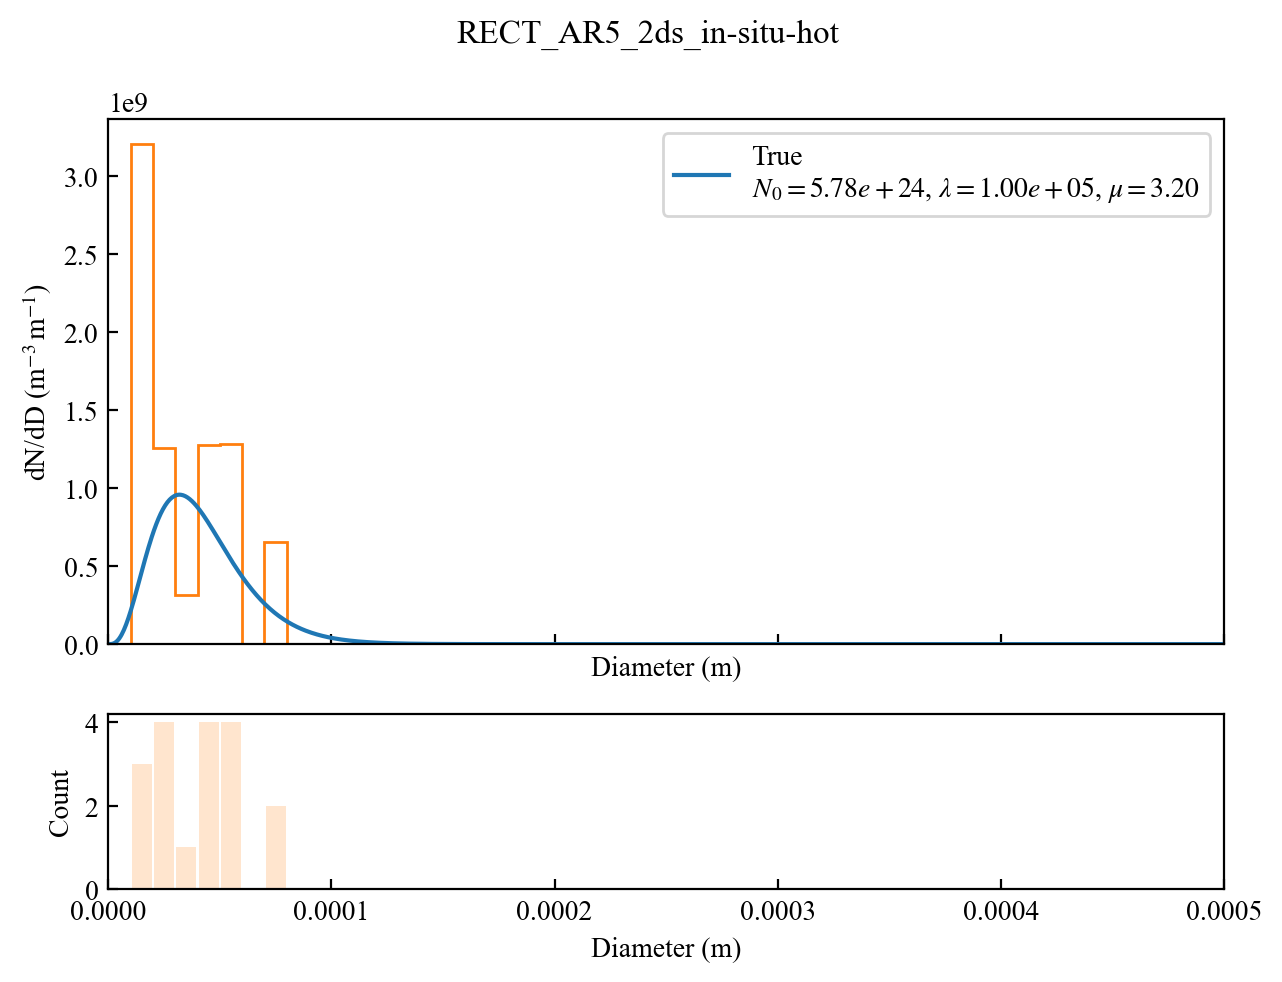

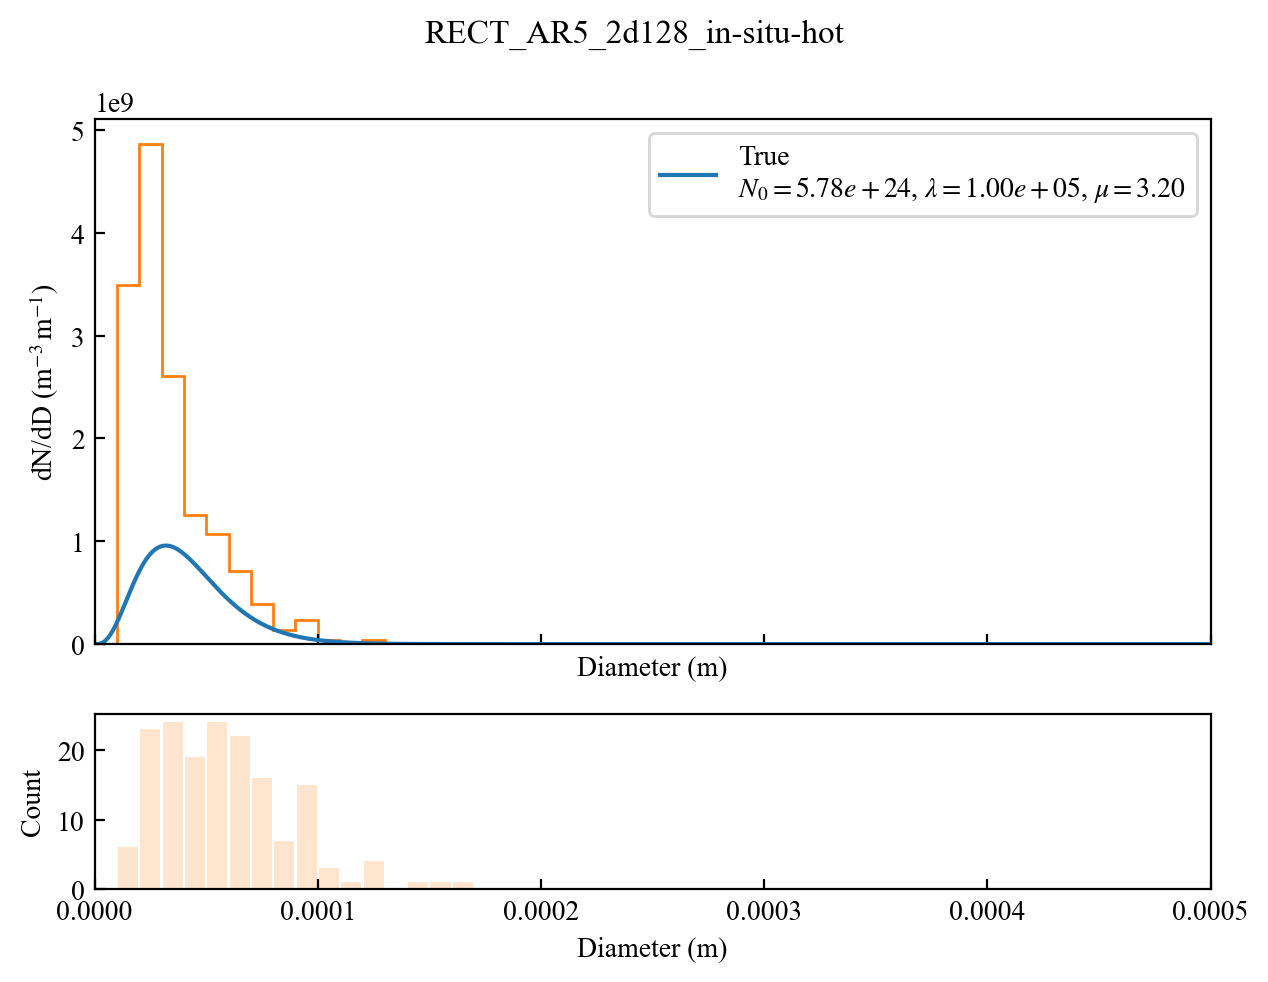

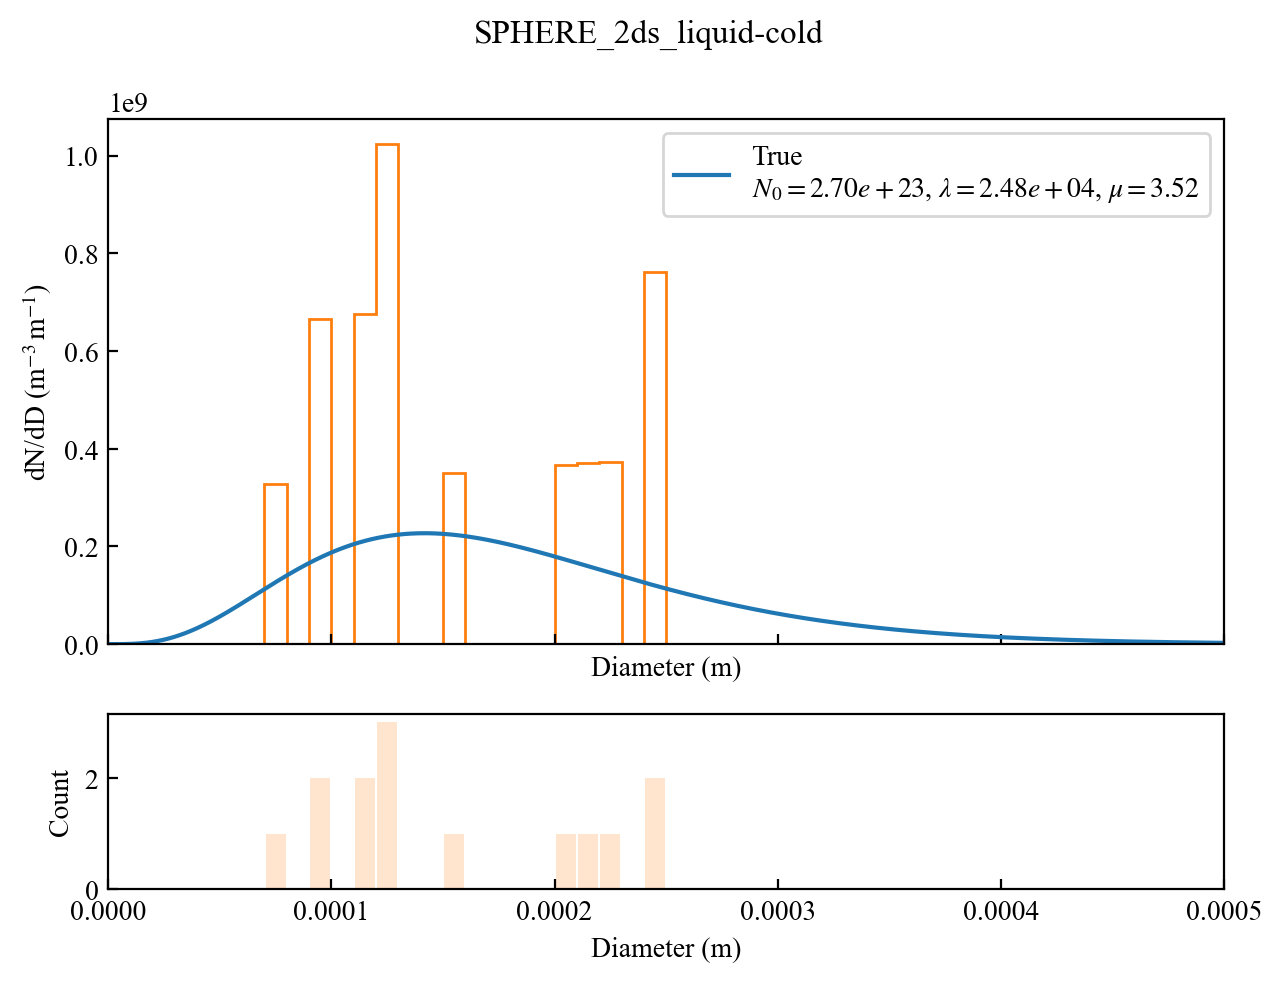

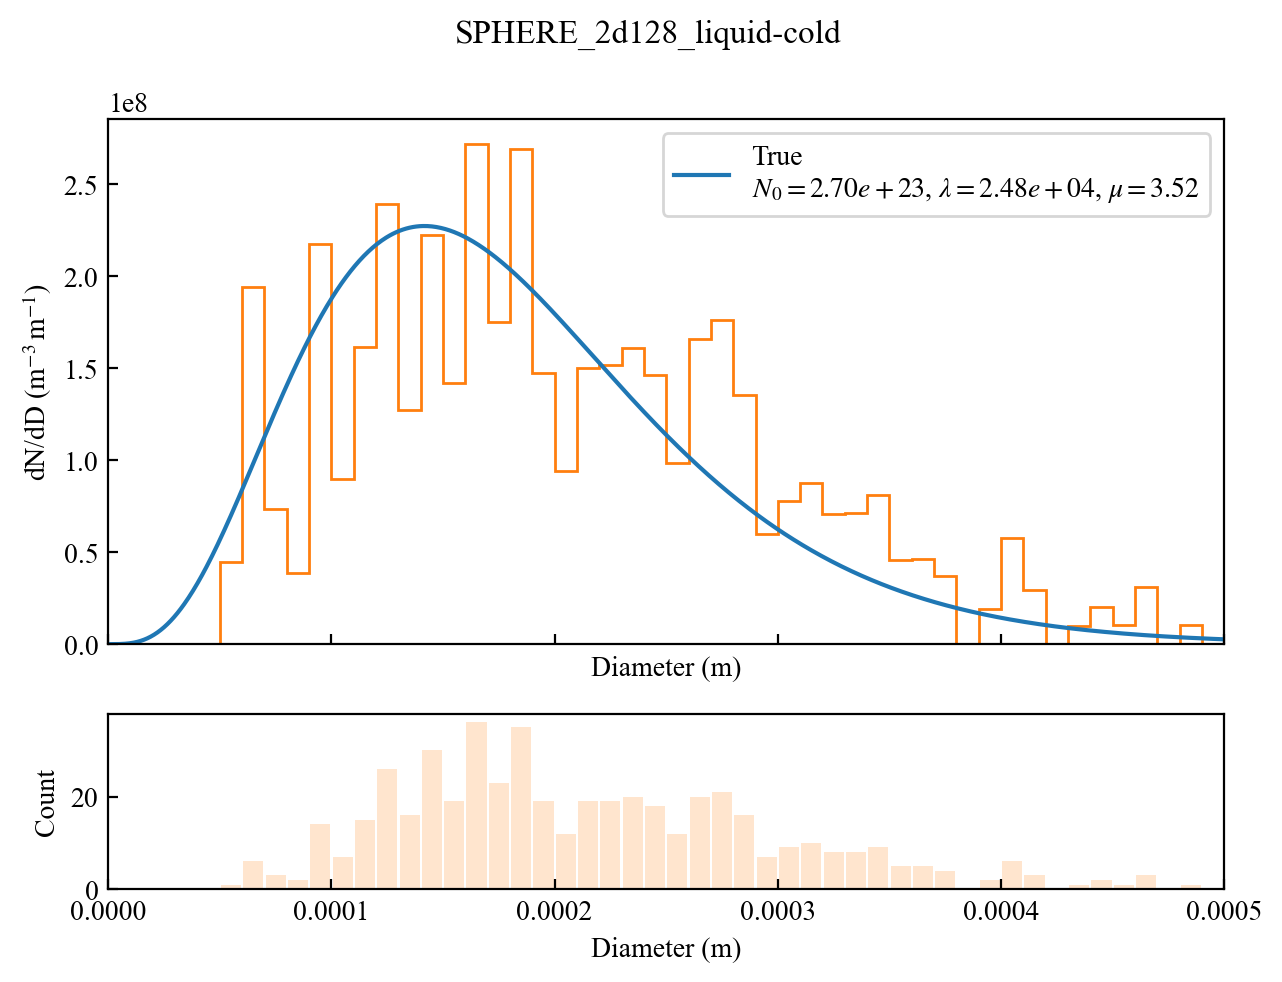

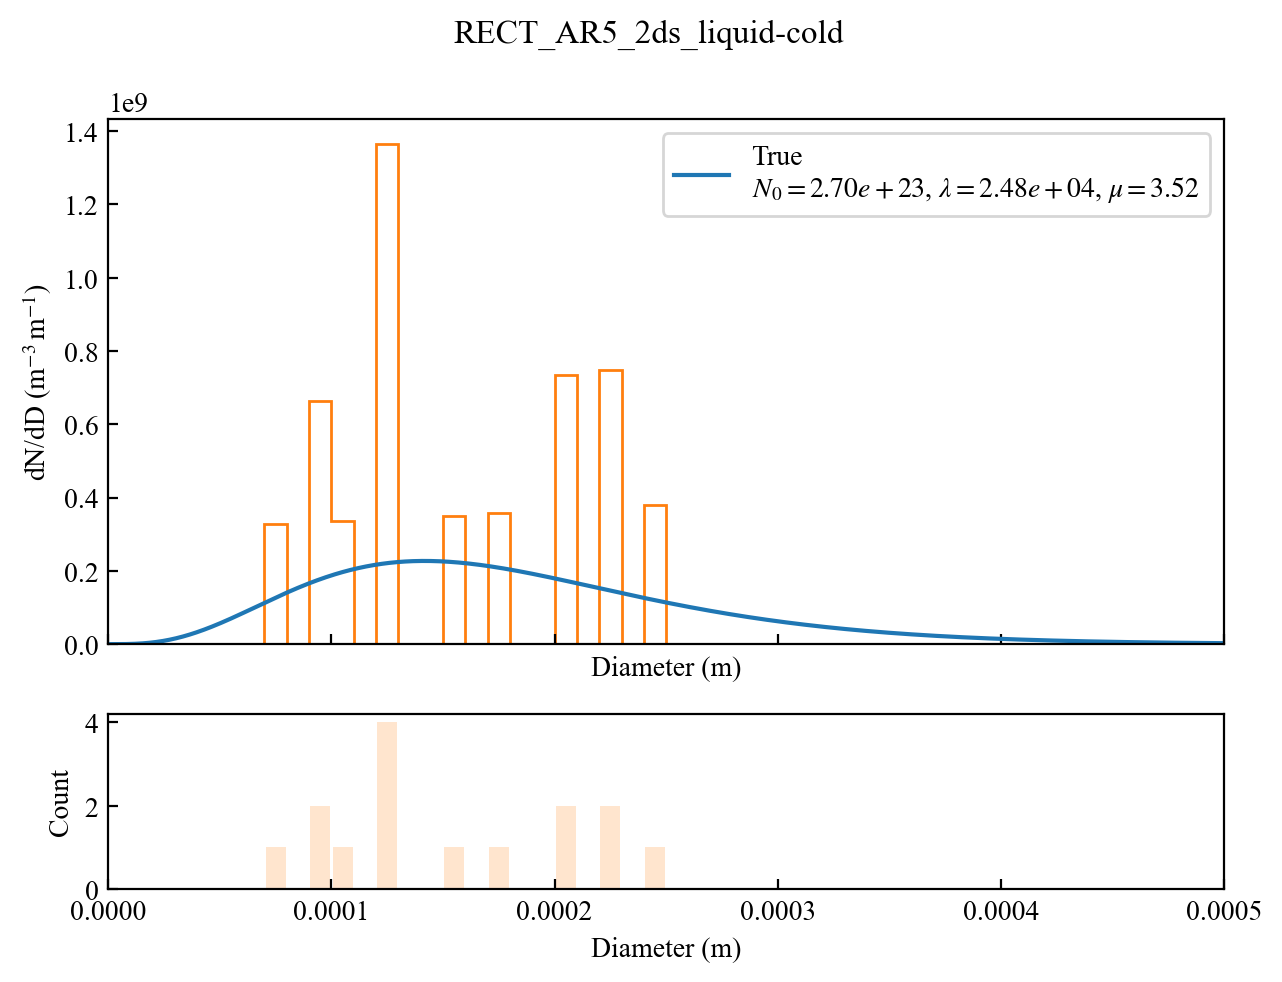

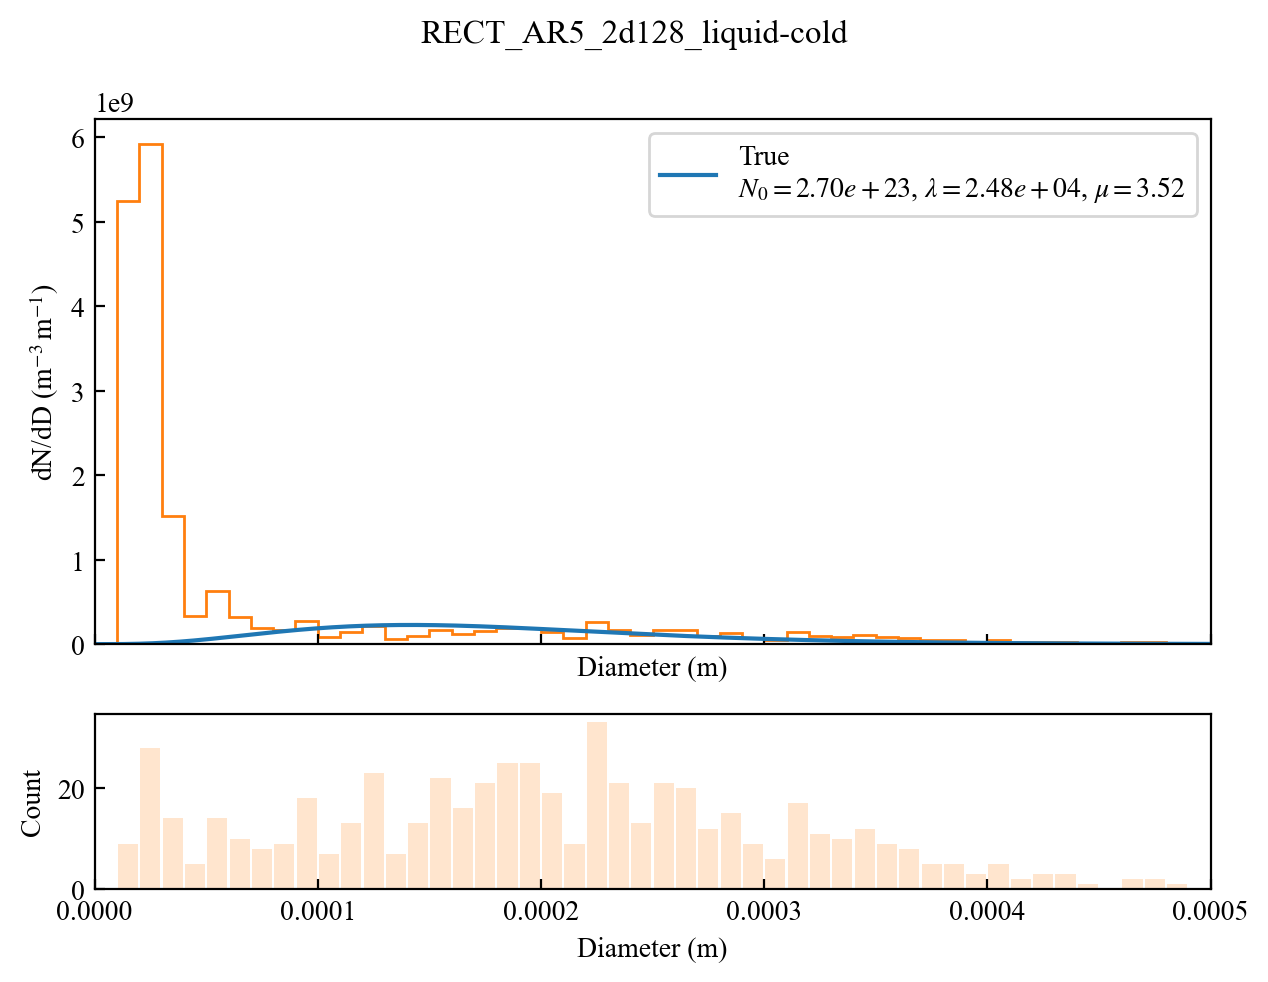

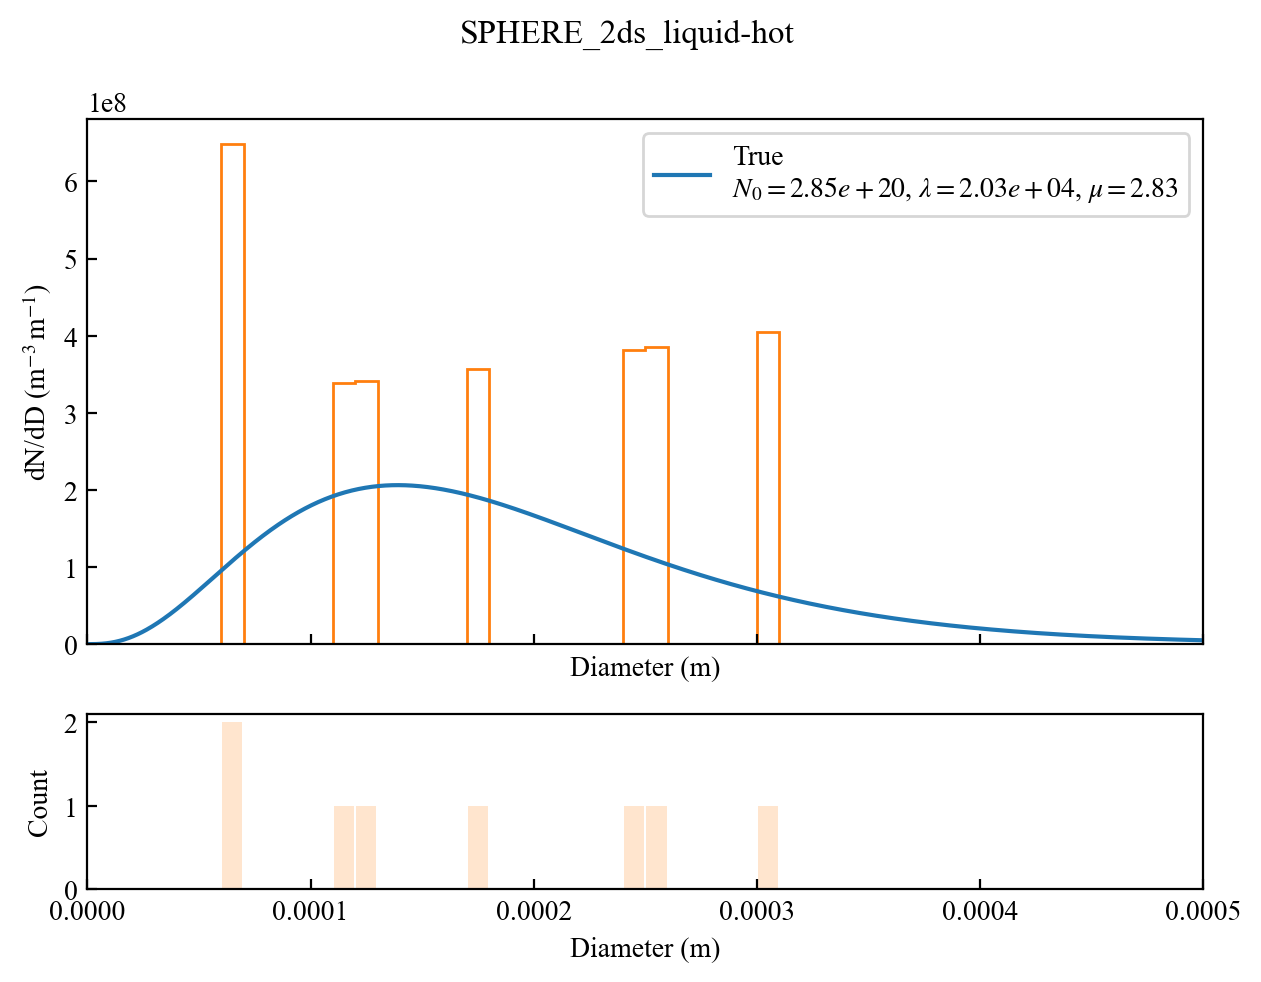

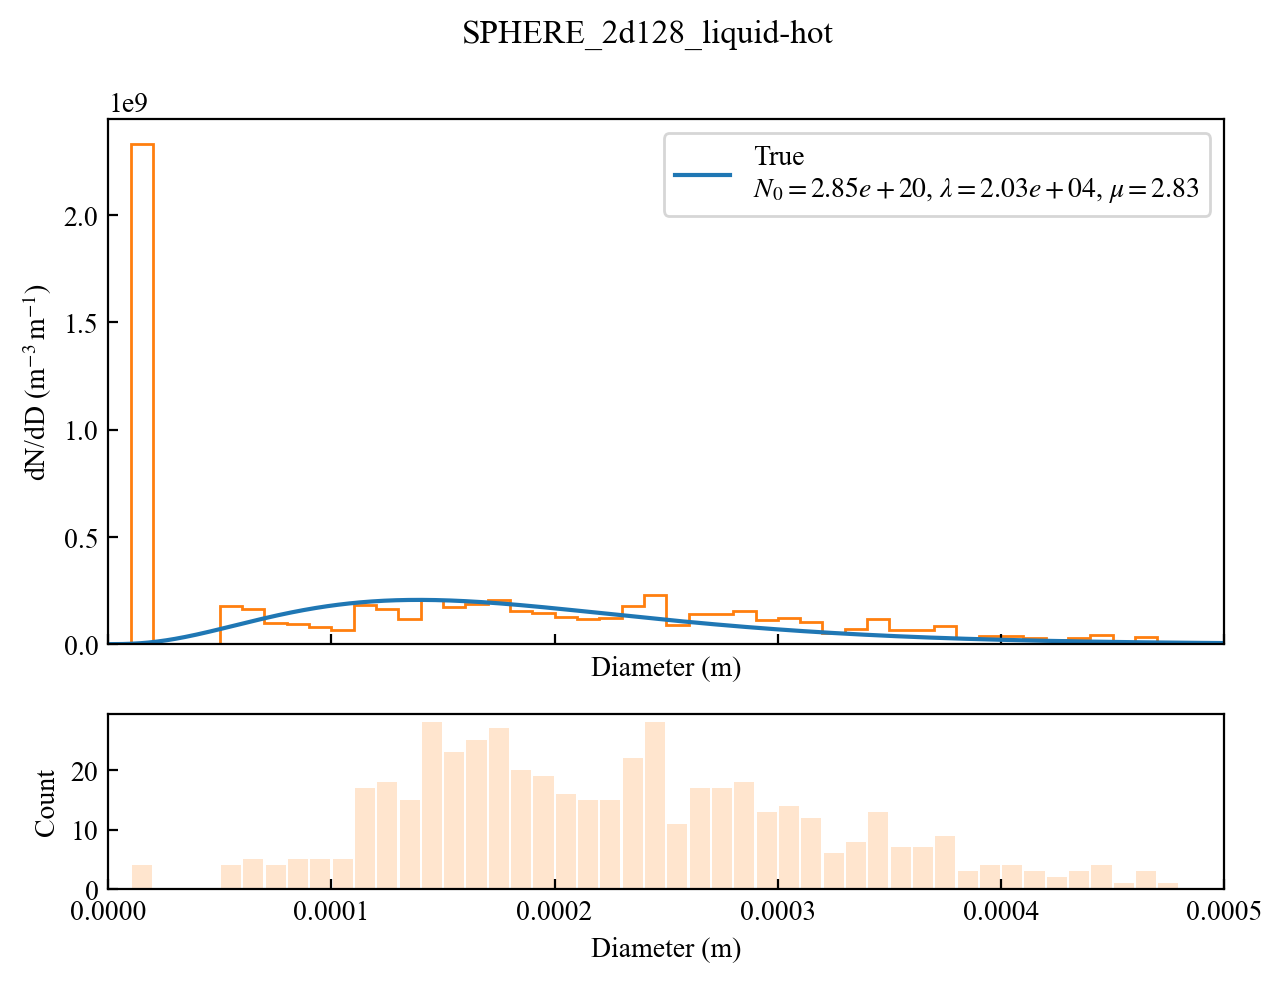

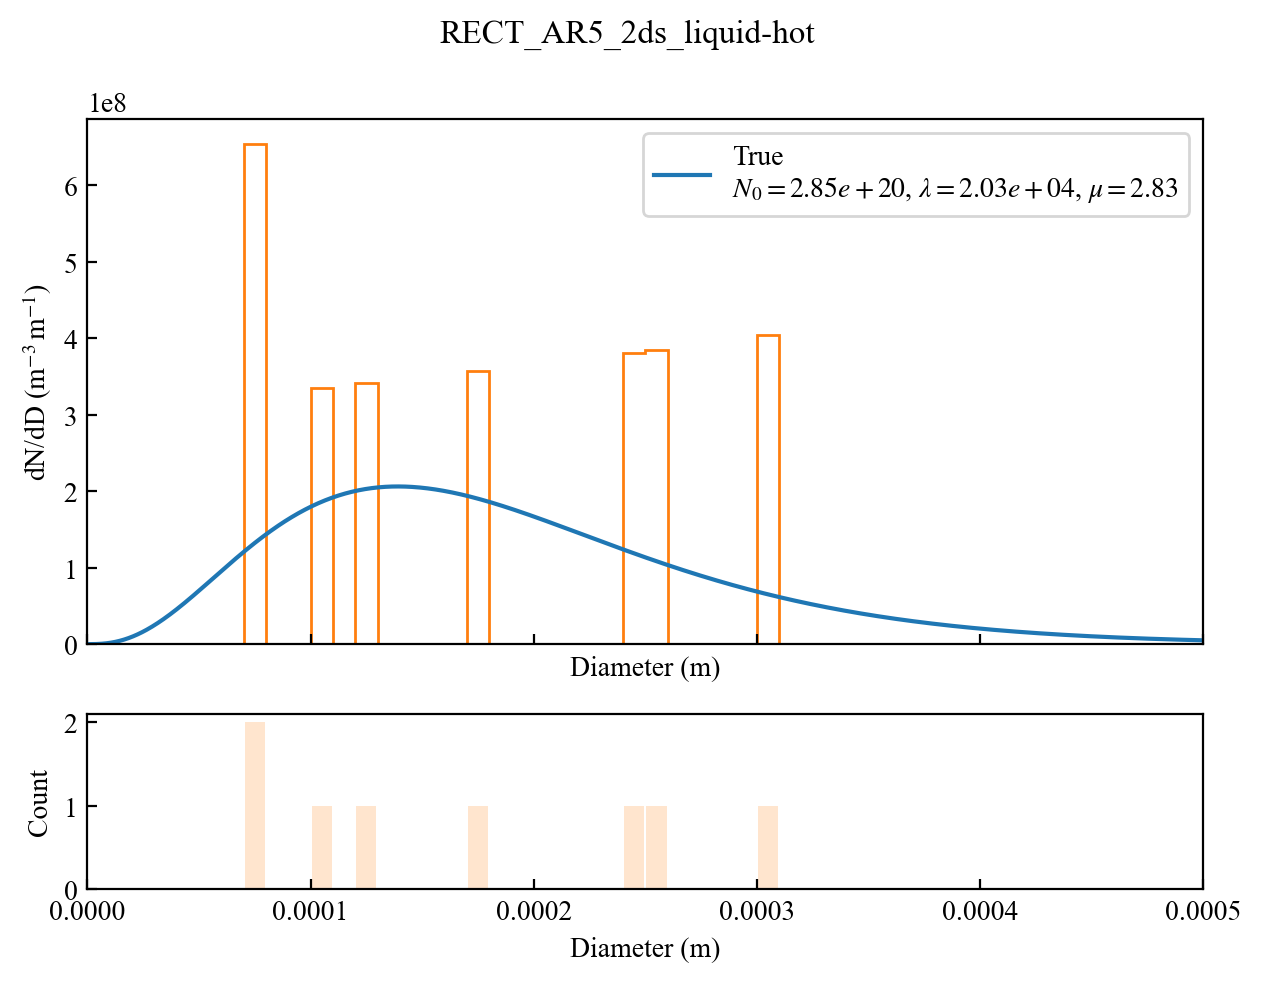

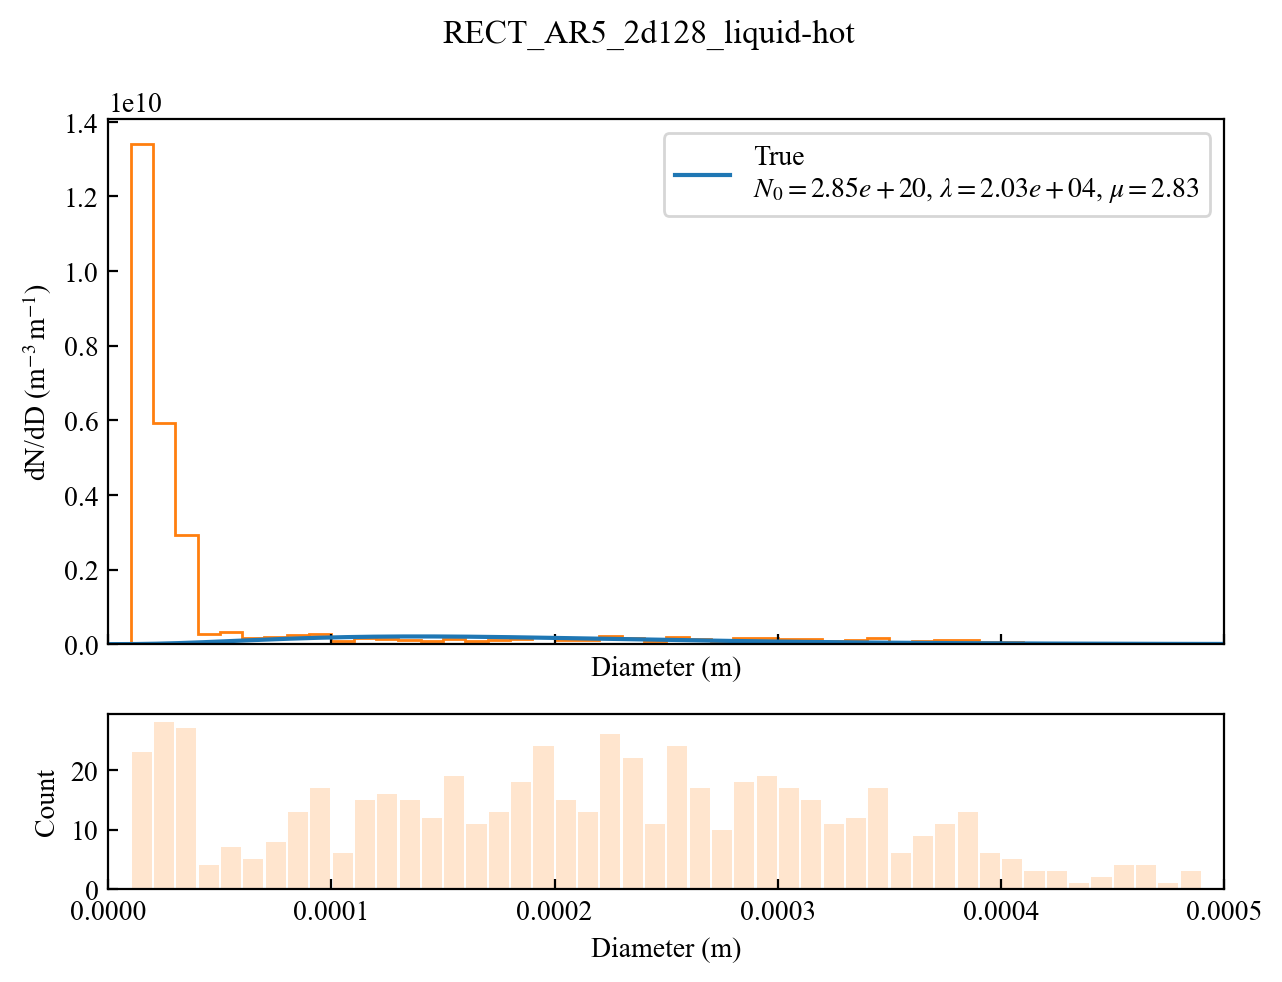

In [7]:
for gamma in gammas.keys():
    for shape_instrument in results.keys():
        best_retrievals, gamma_residuals = results[shape_instrument]
        retrieval_plots(best_retrievals, gamma_residuals, gamma)

[<matplotlib.lines.Line2D object at 0x29c3e54d0>, <matplotlib.lines.Line2D object at 0x29c43af50>]


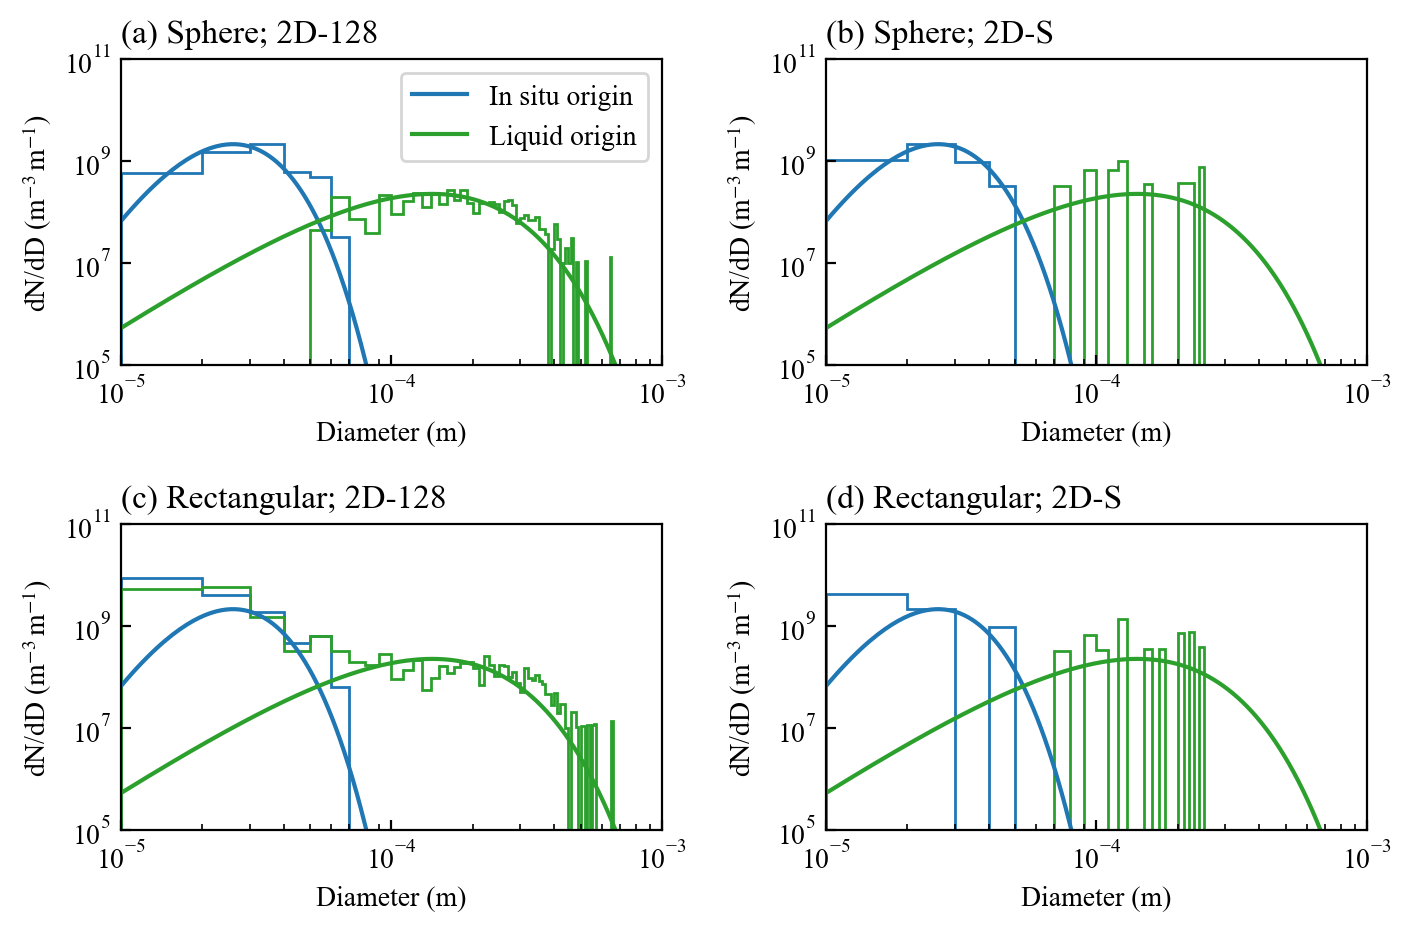

In [8]:

fig, axs = plt.subplots(2,2, figsize=(7.2, 4.8))#, sharex=True, sharey=True)

axs = {
    "SPHERE_2d128": axs[0,0],
    "SPHERE_2ds": axs[0,1],
    "RECT_AR5_2d128": axs[1,0],
    "RECT_AR5_2ds": axs[1,1],
}
letters = iter(["a", "b", "c", "d"])

for shape_instrument in axs.keys():
    if shape_instrument not in results.keys():
        continue
    best_retrievals, gamma_residuals = results[shape_instrument]

    number = 0
    ax = axs[shape_instrument]
    for spec, gamma in gammas.items():
        if "cold" not in spec:
            number += 1
            continue
        gamma.plot(ax=ax, label=f"{spec[0]} origin, {spec[1]} cirrus\n{gamma.parameter_description()}", color=f"C{number}")
        best_retrievals[spec].plot(ax=ax, color=f"C{number}")#, fill=True, alpha=0.2)
        number += 1

    ax.get_legend().remove()
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(1e-5, 1e-3)
    ax.set_ylim(1e5, 1e11)
    title = f"{'Sphere' if shape_instrument.startswith('SPHERE') else 'Rectangular'}; {'2D-S' if shape_instrument.endswith('2ds') else '2D-128'}"
    ax.set_title(f"({next(letters)}) {title}", loc="left")

    if shape_instrument == "SPHERE_2d128":
        h, _ = ax.get_legend_handles_labels()
        print(h)
        # h = [h[0], h[2]]
        ax.legend(h, ["In situ origin", "Liquid origin"],loc="upper right")

plt.tight_layout()
if save_figures:
    plt.savefig("../report/img/psd_retrievals.pdf")
plt.show()

